In [1]:
# ===================== IMPORTS/LIBRARIES =====================
from luxpy import (cat, colortf, _CIEOBS, _CIE_ILLUMINANTS, _CRI_RFL, _CIE_D65,_CIE_E,
                   spd_to_xyz, plot_color_data, math, cie_interp, getwlr, xyz_to_srgb)
from luxpy.utils import np, plt, sp, _PKG_PATH, _SEP, _EPS 
import warnings
from imageio import imsave

import tensorflow as tf
from mtcnn import MTCNN
from pathlib import Path
import pandas as pd
import glob
import cv2
import csv
import os
import ast
import pydot
import pydotplus
import graphviz
from datetime import datetime
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from keras.utils.vis_utils import plot_model

In [2]:
# ===================== CSV HISTORY FUNCTIONS =====================

def historyToCsv(history):
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 
    
    current_datetime = datetime.now()

    # Convert the datetime object to a string
    filename_friendly_datetime_string = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
    
    # save to csv: 
    hist_csv_file = 'history' + filename_friendly_datetime_string + '.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

def csvToHistory(csv_filename):
    # Read the CSV file into a pandas DataFrame
    hist_df = pd.read_csv(csv_filename, index_col=0)

    # Convert the DataFrame to a dictionary
    history_dict = hist_df.to_dict(orient='list')

    return history_dict

In [7]:
# add to imports
from tensorflow.keras.optimizers import Adam

# ===================== MULTITASK MODEL SETUP =====================
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

flattened_features = tf.keras.layers.Flatten(name='flattened_features')(base_model.output)

embedding_layer = tf.keras.layers.Dense(512, activation='linear', name='embedding')(flattened_features)

# additional_dense_layer1 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense1')(embedding_layer)
# additional_Dropout_layer1 = tf.keras.layers.Dropout(0.2)(additional_dense_layer1)
# additional_dense_layer2 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense2')(additional_dense_layer1)
# additional_Norm_layer1 = tf.keras.layers.BatchNormalization()(additional_dense_layer2)
# additional_dense_layer11 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer11')(additional_dense_layer2)
# additional_dense_layer12 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer12')(additional_dense_layer11)
# additional_dense_layer13 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer13')(additional_dense_layer12)
# additional_dense_layer14 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer14')(additional_dense_layer13)

# additional_dense_layer3 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense3')(embedding_layer)
# additional_Dropout_layer2 = tf.keras.layers.Dropout(0.2)(additional_dense_layer3)
# additional_dense_layer4 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense4')(additional_dense_layer3)

# landmarks = tf.keras.layers.Dense(10, activation='linear', name='landmark_output')(additional_dense_layer14)
# landmarks = tf.keras.layers.Dense(10, activation='linear', name='landmark_output')(additional_dense_layer2)
# illum = tf.keras.layers.Dense(1, activation='linear', name='previous_illuminance_output')(additional_dense_layer4)

# Reshape layer to the desired shape
reshaped_features = tf.keras.layers.Reshape((8, 8, 8))(embedding_layer)

# Conv2DTranspose layers instead of UpSampling2D
conv_transpose1 = tf.keras.layers.Conv2DTranspose(8, kernel_size=(3, 3), activation='relu', padding='same', strides=(1, 1))(reshaped_features)
conv_transpose2 = tf.keras.layers.Conv2DTranspose(8, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2))(conv_transpose1)
conv_transpose3 = tf.keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2))(conv_transpose2)
conv_transpose4 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same', strides=(7, 7))(conv_transpose3)

retIllum = tf.keras.layers.Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same', name='image_retinex_output')(conv_transpose4)

task_outputs = None

# task_outputs = [landmarks, illum, retIllum]

task_outputs = [retIllum]

multi_task_model = tf.keras.Model(inputs=base_model.input, outputs=task_outputs)

# Compile the model with specific loss functions and metrics for each task
multi_task_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
#         'landmark_output': 'mean_squared_error',
#         'previous_illuminance_output': 'mean_squared_error',
        'image_retinex_output': 'mean_squared_error'
    },
    metrics={
#         'landmark_output': ['mse', "mae"],
#         'previous_illuminance_output': ['mse', "mae"],
        'image_retinex_output': ['mse', "mae"]
    }
)

multi_task_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [7]:
# add to imports
from tensorflow.keras.optimizers import Adam

# ===================== MULTITASK MODEL SETUP =====================
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# NOTE: MULTITASK W/ Additional Dense Layers w/ dropout(0.5) //Neil
# - edited retinex
# - added dropouts with every dense(0.5)
# - learning_rate=1e-6


flattened_features = tf.keras.layers.Flatten(name='flattened_features')(base_model.output)
embedding_layer = tf.keras.layers.Dense(512, activation='linear', name='embedding')(flattened_features)

# FOR LANDMARKS
additional_Dropout_layer1 = tf.keras.layers.Dropout(0.5)(embedding_layer)

additional_dense_layer1 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense1')(additional_Dropout_layer1)
additional_Dropout_layer2 = tf.keras.layers.Dropout(0.5)(additional_dense_layer1)

additional_dense_layer2 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense2')(additional_Dropout_layer2)
additional_Dropout_layer3 = tf.keras.layers.Dropout(0.5)(additional_dense_layer2)

# BATCH NORMALIZATION
# additional_Norm_layer1 = tf.keras.layers.BatchNormalization()(additional_dense_layer2)

# ADDITIONAL DENSE LAYERS
additional_dense_layer11 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer11')(additional_Dropout_layer3)
additional_Dropout_layer4 = tf.keras.layers.Dropout(0.5)(additional_dense_layer11)

additional_dense_layer12 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer12')(additional_Dropout_layer4)
additional_Dropout_layer5 = tf.keras.layers.Dropout(0.5)(additional_dense_layer12)

additional_dense_layer13 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer13')(additional_Dropout_layer5)
additional_Dropout_layer6 = tf.keras.layers.Dropout(0.5)(additional_dense_layer13)

additional_dense_layer14 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer14')(additional_Dropout_layer6)
additional_Dropout_layer7 = tf.keras.layers.Dropout(0.5)(additional_dense_layer14)

# FOR ILLUMINANCE
additional_Dropout_layer8 = tf.keras.layers.Dropout(0.5)(embedding_layer)

additional_dense_layer3 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense3')(additional_Dropout_layer8)
additional_Dropout_layer9 = tf.keras.layers.Dropout(0.5)(additional_dense_layer3)

additional_dense_layer4 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense4')(additional_Dropout_layer9)
additional_Dropout_layer10 = tf.keras.layers.Dropout(0.5)(additional_dense_layer4)

# landmarks = tf.keras.layers.Dense(10, activation='linear', name='landmark_output')(additional_dense_layer14)

# LANDMARK AND ILLUM OUTPUT
landmarks = tf.keras.layers.Dense(10, activation='linear', name='landmark_output')(additional_Dropout_layer7)
illum = tf.keras.layers.Dense(1, activation='linear', name='previous_illuminance_output')(additional_Dropout_layer10)

# FOR RETINEX
# Reshape layer to the desired shape
reshaped_features = tf.keras.layers.Reshape((8, 8, 8))(embedding_layer)

# Conv2DTranspose layers instead of UpSampling2D
conv_transpose1 = tf.keras.layers.Conv2DTranspose(8, kernel_size=(3, 3), activation='relu', padding='same', strides=(1, 1))(reshaped_features)
conv_transpose2 = tf.keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2))(conv_transpose1)
conv_transpose3 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2))(conv_transpose2)
conv_transpose4 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same', strides=(7, 7))(conv_transpose3)

# RETINEX OUTPUT
retIllum = tf.keras.layers.Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same', name='image_retinex_output')(conv_transpose4)

task_outputs = None

task_outputs = [landmarks, illum, retIllum]

multi_task_model = tf.keras.Model(inputs=base_model.input, outputs=task_outputs)

# Compile the model with specific loss functions and metrics for each task
multi_task_model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss={
        'landmark_output': 'mean_squared_error',
        'previous_illuminance_output': 'mean_squared_error',
        'image_retinex_output': 'mean_squared_error'
    },
    metrics={
        'landmark_output': ['mse', "mae"],
        'previous_illuminance_output': ['mse', "mae"],
        'image_retinex_output': ['mse', "mae"]
    }
)

multi_task_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

 spose)                                                                                           
                                                                                                  
 dropout_22 (Dropout)           (None, 64)           0           ['additional_dense_layer13[0][0]'
                                                                 ]                                
                                                                                                  
 dropout_25 (Dropout)           (None, 64)           0           ['additional_dense3[0][0]']      
                                                                                                  
 conv2d_transpose_9 (Conv2DTran  (None, 16, 16, 16)  1168        ['conv2d_transpose_8[0][0]']     
 spose)                                                                                           
                                                                                                  
 additiona

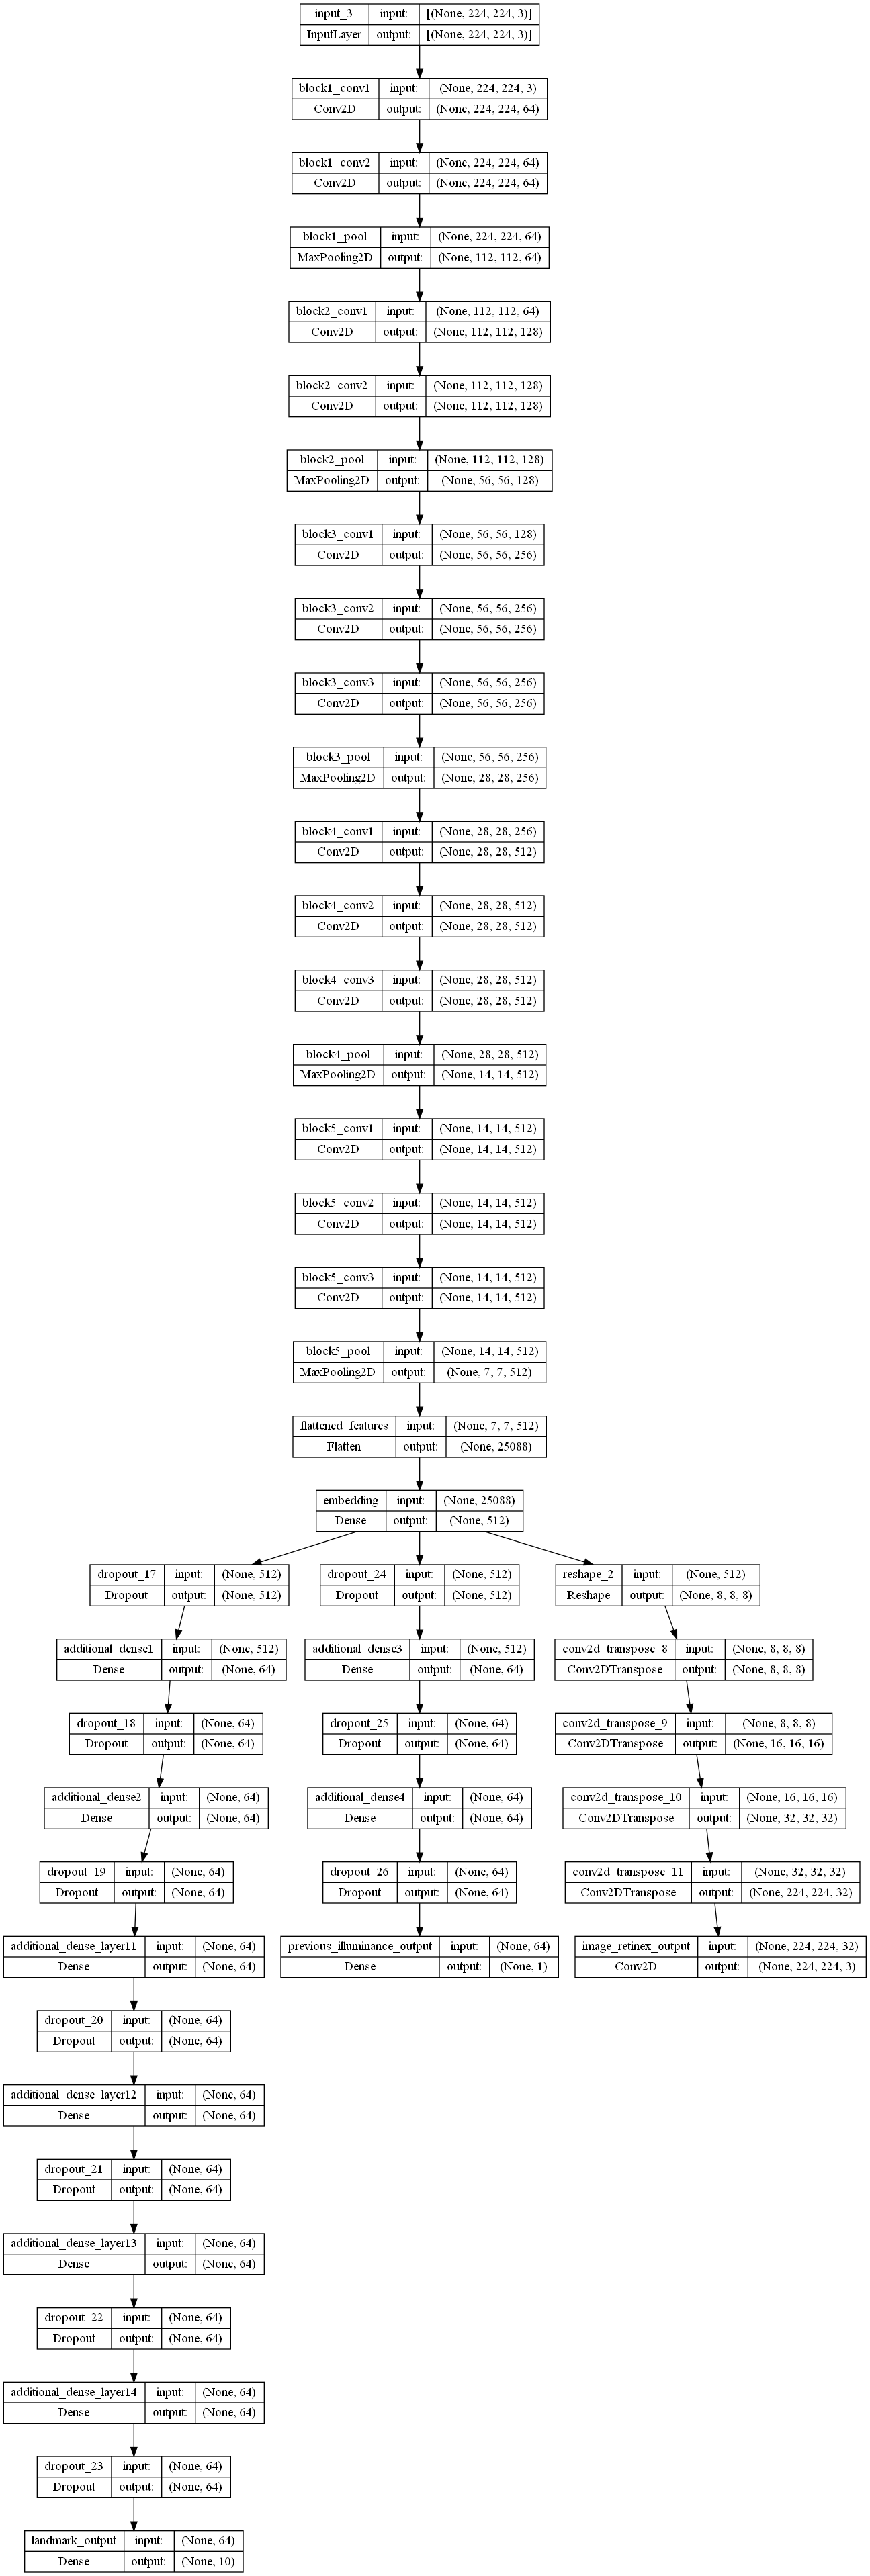

In [8]:
import pydot
import graphviz
import matplotlib.pyplot as plt
tf.keras.utils.plot_model(multi_task_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
# # ===================== MULTI-TASK DATA GEN =====================

# class CustomDataGen(tf.keras.utils.Sequence):
    
#     def __init__(self, df, X_col, y_col,
#                  batch_size,
#                  input_size=(224, 224, 3),
#                  shuffle=True,
#                  random_seed=None):  # Add a new parameter for random seed
        
#         self.df = df.copy()
#         self.X_col = X_col
#         self.y_col = y_col
#         self.batch_size = batch_size
#         self.input_size = input_size
#         self.shuffle = shuffle
#         self.random_seed = random_seed  # Store the random seed
        
#         self.n = len(self.df)
#         self.n_coords = 2  # Assuming landmark coordinates are 2-dimensional
#         self.n_illuminance = 1  # Assuming a single illuminance value
    
#     def on_epoch_end(self):
#         if self.shuffle:
#             self.df = self.df.sample(frac=1, random_state=self.random_seed).reset_index(drop=True)  # Use the random seed
    
#     def __get_input(self, path, target_size):
    
#         image = tf.keras.preprocessing.image.load_img(path)
#         image_arr = tf.keras.preprocessing.image.img_to_array(image)

#         image_arr = tf.image.resize(image_arr, (target_size[0], target_size[1])).numpy()

#         return image_arr / 255.
    
#     def __get_output(self, label, output_type):
#         # Assuming output_type is 'coordinates', 'illuminance', or 'adjusted_image_path'
#         if output_type == 'coordinates':
#             # Assuming label is a string containing a dictionary-like structure
#             # Safely evaluate the string as a literal dictionary using ast.literal_eval
#             coordinates_dict = ast.literal_eval(label)
            
#             # Extract x and y coordinates for each landmark
#             landmarks = ['left_eye', 'right_eye', 'nose', 'mouth_left', 'mouth_right']
#             coordinates_list = [coordinates_dict[landmark] for landmark in landmarks]
            
#             # Flatten the list and convert to numpy array
#             coordinates_array = np.array([coord for landmark_coords in coordinates_list for coord in landmark_coords])
#             print(f'original coords: {coordinates_array}')
            
# #             print("Shape of landmarks_array:", coordinates_array.shape)
            
#             # If there are exactly 10 values, return the array, otherwise raise an error
#             if len(coordinates_array) == 10:
#                 return coordinates_array
#             else:
#                 raise ValueError("Expected 10 coordinates, but found {}".format(len(coordinates_array)))
#         elif output_type == 'illuminance':
#             # Convert the illuminance value to a float
#             return float(label)
#         elif output_type == 'adjusted_image_path':
#             # Assuming label is the path to the adjusted image
#             return self.__get_input(label, self.input_size)
    
#     def __get_data(self, batches):
#         # Generates data containing batch_size samples

#         path_batch = batches[self.X_col['path']]
        
#         coords_batch = batches[self.y_col['coordinates']]
#         illuminance_batch = batches[self.y_col['illuminance']]
#         adjusted_image_path_batch = batches[self.y_col['adjusted_image_path']]

#         X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])

#         y0_batch = np.asarray([self.__get_output(y, 'coordinates') for y in coords_batch])
#         y1_batch = np.asarray([self.__get_output(y, 'illuminance') for y in illuminance_batch])
#         y2_batch = np.asarray([self.__get_output(y, 'adjusted_image_path') for y in adjusted_image_path_batch])
        
#         return X_batch, [y0_batch, y1_batch, y2_batch]
    
#     def __getitem__(self, index):
#         batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
#         X, y = self.__get_data(batches)
        
#         return X, y
    
#     def __len__(self):
#         return self.n // self.batch_size

In [20]:
# ===================== MULTI-TASK DATA GEN =====================

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(224, 224, 3),
                 shuffle=True,
                 random_seed=None):  # Add a new parameter for random seed
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.random_seed = random_seed  # Store the random seed
        
        self.n = len(self.df)
        self.n_coords = 2  # Assuming landmark coordinates are 2-dimensional
        self.n_illuminance = 1  # Assuming a single illuminance value
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1, random_state=self.random_seed).reset_index(drop=True)  # Use the random seed
    
    def __get_input(self, path, target_size):
    
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)

        image_arr = tf.image.resize(image_arr, (target_size[0], target_size[1])).numpy()

        return image_arr / 255.
    
    def __get_output(self, label, output_type):
        # Assuming output_type is 'coordinates', 'illuminance', or 'adjusted_image_path'
#         if output_type == 'coordinates':
#             # Assuming label is a string containing a dictionary-like structure
#             # Safely evaluate the string as a literal dictionary using ast.literal_eval
#             coordinates_dict = ast.literal_eval(label)
            
#             # Extract x and y coordinates for each landmark
#             landmarks = ['left_eye', 'right_eye', 'nose', 'mouth_left', 'mouth_right']
#             coordinates_list = [coordinates_dict[landmark] for landmark in landmarks]
            
#             # Flatten the list and convert to numpy array
#             coordinates_array = np.array([coord for landmark_coords in coordinates_list for coord in landmark_coords])
            
#             coordinates_array = normalize_coordinates(coordinates_array, 640, 480)

# #             print("Shape of landmarks_array:", coordinates_array.shape)
            
#             # If there are exactly 10 values, return the array, otherwise raise an error
#             if len(coordinates_array) == 10:
#                 return coordinates_array
#             else:
#                 raise ValueError("Expected 10 coordinates, but found {}".format(len(coordinates_array)))
#         elif output_type == 'illuminance':
#             # Convert the illuminance value to a float
#             return float(label)
        if output_type == 'adjusted_image_path':
            # Assuming label is the path to the adjusted image
            return self.__get_input(label, self.input_size)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['path']]
        
#         coords_batch = batches[self.y_col['coordinates']]
#         illuminance_batch = batches[self.y_col['illuminance']]
        adjusted_image_path_batch = batches[self.y_col['adjusted_image_path']]

        X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])

#         y0_batch = np.asarray([self.__get_output(y, 'coordinates') for y in coords_batch])
#         y1_batch = np.asarray([self.__get_output(y, 'illuminance') for y in illuminance_batch])
        y2_batch = np.asarray([self.__get_output(y, 'adjusted_image_path') for y in adjusted_image_path_batch])

#         return X_batch, [y0_batch, y1_batch, y2_batch]
        return X_batch, [y2_batch]
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

def normalize_coordinates(coordinates, original_width, original_height):
    normalized_coordinates = np.zeros_like(coordinates, dtype=np.float32)
    
    for i in range(0, len(coordinates), 2):
        x = coordinates[i]
        y = coordinates[i + 1]
        
        normalized_x = (x / original_width)
        normalized_y = (y / original_height)
        
        normalized_coordinates[i] = normalized_x
        normalized_coordinates[i + 1] = normalized_y
    
    return normalized_coordinates

In [21]:
# ===================== DATA GEN SETUP =====================

train_df = pd.read_csv(r".\training.csv") # path to train_data csv
train_df["Filename"] = "./data/Training/" + train_df["Filename"]
train_df["Retinex"] = "./retinex_results_train/" + train_df["Retinex"]

# Define column indices or names for X and y
X_col = {'path': 'Filename'}
# y_col = {'illuminance': 'Illuminance', 'coordinates': 'Landmarks', 'adjusted_image_path': 'Retinex'}
y_col = {'adjusted_image_path': 'Retinex'}

# Create an instance of CustomDataGen
train_gen = CustomDataGen(train_df, X_col, y_col, batch_size=32, input_size=(224, 224, 3), random_seed=438)

eval_df = pd.read_csv(r".\evaluation.csv") # path to eval_data csv
eval_df["Filename"] = "./data/Evaluation/" + eval_df["Filename"]
eval_df["Retinex"] = "./retinex_results_eval/" + eval_df["Retinex"]

# Define column indices or names for X and y
eval_X_col = {'path': 'Filename'}
# eval_y_col = {'illuminance': 'Illuminance', 'coordinates': 'Landmarks', 'adjusted_image_path': 'Retinex'}
eval_y_col = {'adjusted_image_path': 'Retinex'}


val_gen = CustomDataGen(eval_df, eval_X_col, eval_y_col, batch_size=32, input_size=(224, 224, 3), random_seed=438)
# print(eval_df)
# print(train_df)

In [22]:
class DynamicLearningRateScheduler(Callback):
    def __init__(self, monitor_metric='val_loss', patience=3, factor=0.5, min_lr=1e-6):
        super(DynamicLearningRateScheduler, self).__init__()
        self.monitor_metric = monitor_metric
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.wait = 0
        self.best_metric = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_metric = logs.get(self.monitor_metric)

        if current_metric is None:
            raise ValueError(f"Metric {self.monitor_metric} not found in training logs.")

        if current_metric < self.best_metric:
            self.best_metric = current_metric
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = max(self.model.optimizer.lr * self.factor, self.min_lr)
                self.model.optimizer.lr = new_lr
                print(f"\nLearning rate reduced to {new_lr}.")
                self.wait = 0

dynamicLearningCallback = DynamicLearningRateScheduler(monitor_metric='val_loss', patience=3, factor=0.5, min_lr=1e-6)

class SaveModelEveryNEpochs(Callback):
    def __init__(self, save_path, save_freq=5):
        super(SaveModelEveryNEpochs, self).__init__()
        self.save_path = save_path
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            model_filename = f"{self.save_path}_epoch_{epoch + 1}.keras"
            self.model.save(model_filename)
            print(f"\nModel saved to {model_filename}.")

callback_save_path = "./Callback_Models"  # Change this to your desired save path
saveModelCallback = SaveModelEveryNEpochs(callback_save_path, save_freq=5)

In [24]:
history = multi_task_model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[dynamicLearningCallback, saveModelCallback])

Epoch 1/20
940/940 [==============================] - 1935s 2s/step - loss: 0.0972 - mse: 0.0972 - mae: 0.2399 - val_loss: 0.0537 - val_mse: 0.0537 - val_mae: 0.1848
Epoch 2/20
263/940 [=======>......................] - ETA: 21:25 - loss: 0.0462 - mse: 0.0462 - mae: 0.1640

KeyboardInterrupt: 

In [ ]:
# ===================== SAVE MODEL WEIGHTS =====================

multi_task_model.save('RetinexOnlyModel.keras')
history.history

In [ ]:
# # ===================== PLOT MODEL =====================
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc='upper right')

# # Plot training & validation loss values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['landmark_output_loss'])
# plt.plot(history.history['val_landmark_output_loss'])
# plt.title('Landmarks Task Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc='upper right')

# # Plot training & validation loss values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['landmark_output_mse'])
# plt.plot(history.history['val_landmark_output_mse'])
# plt.title('Landmarks Task MSE')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc='upper right')

# # Plot training & validation loss values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['landmark_output_mae'])
# plt.plot(history.history['val_landmark_output_mae'])
# plt.title('Landmarks Task MAE')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc='upper right')

# # Plot training & validation loss values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['previous_illuminance_output_loss'])
# plt.plot(history.history['val_previous_illuminance_output_loss'])
# plt.title('Illuminance Task Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc='upper right')

# # Plot training & validation loss values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['previous_illuminance_output_mse'])
# plt.plot(history.history['val_previous_illuminance_output_mse'])
# plt.title('Illuminance Task MSE')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc='upper right')

# # Plot training & validation loss values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['previous_illuminance_output_mae'])
# plt.plot(history.history['val_previous_illuminance_output_mae'])
# plt.title('Illuminance Task MAE')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc='upper right')

# # Plot training & validation loss values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['image_retinex_output_loss'])
# plt.plot(history.history['val_image_retinex_output_loss'])
# plt.title('Retinex Task Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc='upper right')

# # Plot training & validation loss values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['image_retinex_output_mse'])
# plt.plot(history.history['val_image_retinex_output_mse'])
# plt.title('Landmarks Task MSE')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc='upper right')

# # Plot training & validation loss values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['image_retinex_output_mae'])
# plt.plot(history.history['val_image_retinex_output_mae'])
# plt.title('Landmarks Task MAE')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc='upper right')

# plt.tight_layout()
# plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['landmark_output_loss'])
plt.plot(history.history['val_landmark_output_loss'])
plt.title('Landmarks Task Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['landmark_output_mse'])
plt.plot(history.history['val_landmark_output_mse'])
plt.title('Landmarks Task MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['landmark_output_mae'])
plt.plot(history.history['val_landmark_output_mae'])
plt.title('Landmarks Task MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['previous_illuminance_output_loss'])
plt.plot(history.history['val_previous_illuminance_output_loss'])
plt.title('Illuminance Task Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['previous_illuminance_output_mse'])
plt.plot(history.history['val_previous_illuminance_output_mse'])
plt.title('Illuminance Task MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['previous_illuminance_output_mae'])
plt.plot(history.history['val_previous_illuminance_output_mae'])
plt.title('Illuminance Task MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['image_retinex_output_loss'])
plt.plot(history.history['val_image_retinex_output_loss'])
plt.title('Retinex Task Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['image_retinex_output_mse'])
plt.plot(history.history['val_image_retinex_output_mse'])
plt.title('Retinex Task MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['image_retinex_output_mae'])
plt.plot(history.history['val_image_retinex_output_mae'])
plt.title('Retinex Task MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()